In [29]:
import numpy as np
from loss import *
from utils import *
import skopt
from matplotlib import pyplot as plt
from skopt import gp_minimize
import pandas as pd

import warnings
warnings.filterwarnings(action='once')

from skopt.learning import (GaussianProcessRegressor, RandomForestRegressor,
                            GradientBoostingQuantileRegressor)

from multiprocessing import Pool, Process
from skopt import Optimizer

In [89]:
%%time
results = []
def run_optimization(args, points=300, acq='PI'):
    func = args[0]
    random_state = args[1]
    
    opt = Optimizer(dimensions=[(0.0, 20.0), (0.0, 20.0)], base_estimator=GaussianProcessRegressor(
                alpha=1e-3, noise='gaussian'), acq_func='PI', random_state=random_state)
    for i in range(points):
        x = opt.ask()
        y = func(x)
        opt.tell(x, y)
        if np.linalg.norm(x) < 0.01:
            return opt
    return opt

p = Pool(4)

for i in range(10):
    args = [(LossPois(seed=1), i * 10 + x) for x in range(4)]
    for arg in args:
        arg[0](np.ones(2), sample_share=1, update_weights=True)


    res = p.map(run_optimization, args)
    results += res

p.close()

CPU times: user 24.8 s, sys: 1min 27s, total: 1min 52s
Wall time: 12h 4min 41s


In [90]:
obj = LossPois(seed=1)

In [91]:
obj_values = []
for opt in results:
    values = []
    for x in opt.Xi:
        values.append(obj(np.array(x)))
    obj_values.append(values)

In [109]:
mean_vector = []
for i in range(0, len(obj_values)):
    def sup(x):
        if len(x) > i:
            return x[i]
        else:
            return np.nan
    res = np.array(list(map(sup, obj_values)))
    mean_vector.append(np.mean(res[np.logical_not(np.isnan(res))]))

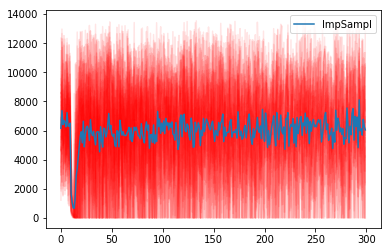

In [111]:
for row in np_obj_values:
    plt.plot(row, c='r',alpha=0.1)
plt.plot(mean_vector)
plt.legend()
plt.show()

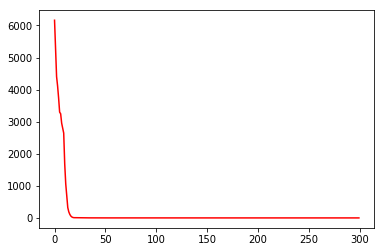

In [116]:
cum_minima = pd.DataFrame(obj_values).cummin(axis=1).mean(axis=0)
plt.plot(cum_minima, c='r')

plt.legend()
plt.show()